In [1]:
import datetime as dt
import os

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(".\src\stylesheets\eb3.mplstyle")

from src.sensor_reader import import_data
from src.project_definitions import BUID, dir_results
from src.utilities import INDOC
from src.update_databases import up

### update database ###
up()

IND = import_data(mode='IND')

30.03.2022 16:42:16 -- INFO -- ------ Starte TinkerForge Update------
30.03.2022 16:42:16 -- INFO -- MH wurde übersprungen.
30.03.2022 16:42:16 -- INFO -- MW wurde übersprungen.
30.03.2022 16:42:16 -- INFO -- LB wurde übersprungen.
30.03.2022 16:42:16 -- INFO -- PM wurde übersprungen.
30.03.2022 16:42:16 -- INFO -- WD wurde übersprungen.
30.03.2022 16:42:16 -- INFO -- ------TinkerForge Update beendet!------
30.03.2022 16:42:16 -- INFO -- Molline-Datenbank up-to-date. Kein Update notwendig.


# Analyse der zusätzlich installierten Sensoren (Dezember 2021)
## 1. Abweichung der Luftfeuchten zwischen Gesamtsystem und Einzelsensor

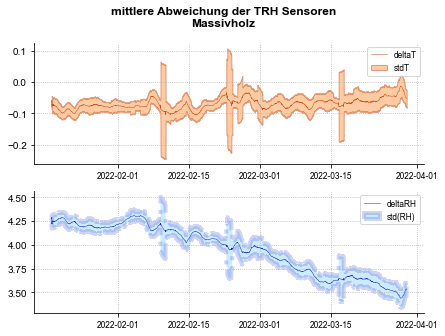

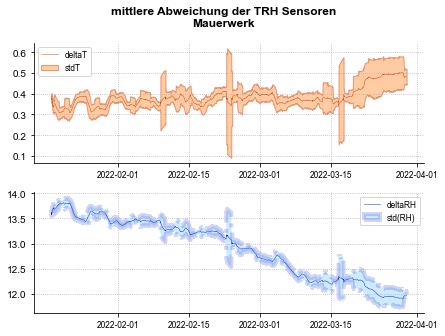

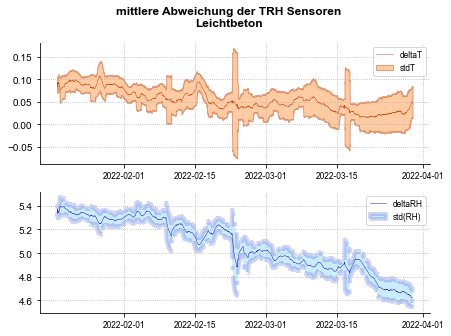

In [2]:
mittlere_abweichung = {}
TEMP = []
RH = []
for bui in BUID:
    fig, axs = plt.subplots(2, figsize=INDOC)
    fig.suptitle(f'mittlere Abweichung der TRH Sensoren\n{BUID[bui]}')
    temp = IND[bui]['O']['SWK'].filter(like='Tair').filter(like='trh')
    
    temp = temp.diff(axis=1).dropna(how='all',axis=1).dropna(axis=0)
    #temp = temp.mean(axis=1).dropna()
    temp.columns = [f'{bui}_deltaT']
    TEMP.append(temp)
    dot = temp.index
    mean = temp.rolling('24H').mean()
    error = temp.rolling('24H').std()

    axs[0].plot(mean, color='#CC4F1B',label = 'deltaT')
    axs[0].fill_between(dot, np.array(mean-error).flatten(), np.array(mean+error).flatten(), alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', label='stdT')
    axs[0].legend()

    rh = IND[bui]['O']['SWK'].filter(like='RH').filter(like='trh')

    rh = rh.diff(axis=1).dropna(how='all',axis=1).dropna(axis=0)
    #rh = rh.mean(axis=1).dropna()
    rh.columns = [f'{bui}_deltaRH']
    RH.append(rh)
    dot = rh.index
    mean = rh.rolling('24H').mean()
    error = rh.rolling('24H').std()

    axs[1].plot(mean, color='#1B2ACC',label='deltaRH')
    axs[1].fill_between(dot, np.array(mean-error).flatten(), np.array(mean+error).flatten(), alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=4, linestyle='dashdot', antialiased=True,label='std(RH)')
    axs[1].legend()

    fig.tight_layout()

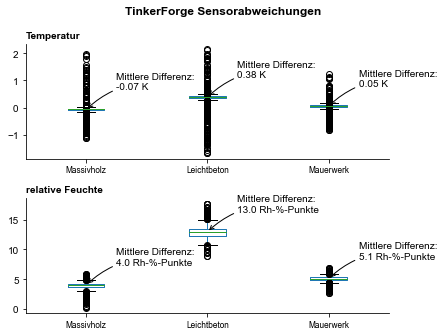

In [3]:
fig, axs = plt.subplots(2,1, figsize = INDOC)
fig.suptitle('TinkerForge Sensorabweichungen')
axs[0].set_title('Temperatur')
box_temp = pd.concat(TEMP)
box_temp.columns = ['Massivholz', 'Leichtbeton', 'Mauerwerk']
for i, (name, value) in enumerate(box_temp.mean().iteritems()):
    axs[0].annotate(f'Mittlere Differenz:\n{value:.2f} K', (i+1,value),xycoords='data', xytext=(30, 20), textcoords='offset points',arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2"))
box_temp.boxplot(ax=axs[0],grid=False)
axs[1].set_title('relative Feuchte')
box_hum = pd.concat(RH)
box_hum.columns = ['Massivholz', 'Leichtbeton', 'Mauerwerk']
box_hum.boxplot(ax=axs[1],grid=False)
for i, (name, value) in enumerate(box_hum.median().iteritems()):
    axs[1].annotate(f'Mittlere Differenz:\n{value:.1f} Rh-%-Punkte', (i+1,value),xycoords='data', xytext=(30, 20), textcoords='offset points',arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2"))

for ax in axs:
    ax.spines['bottom'].set_visible(True)
fig.tight_layout()
if not os.path.isdir(os.path.join(dir_results,'Allgemein')):os.makedirs(os.path.join(dir_results,'Allgemein'))
fig.savefig(os.path.join(dir_results,'Allgemein','TinkerForge_Abweichungen.pdf'),dpi=300)

In [4]:
df = pd.DataFrame([pd.concat(RH).median(), pd.concat(TEMP).median()]).T
df.to_csv('.\src\KorrekturFaktoren.csv')